In [ ]:
!pip install -q efficientnet
!pip install tf-nightly
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import pandas as pd
import numpy as np

import cv2
#import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

from tqdm import tqdm as tqdm
import gc


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [ ]:
! pip install numpy

In [ ]:
def InitializeSession():
    tf.compat.v1.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.set_random_seed(123)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
def load_image(image_id, label=None, image_size=None):

    if image_id.numpy().decode("utf-8").split('_')[0]=='gan' and len(image_id.numpy().decode("utf-8").split('_'))==2:
        image_id = int(image_id.numpy().decode("utf-8").split('_')[1])
        return md_gan[image_id], [0,1,0,0]
    else:
        bits = tf.io.read_file(image_id)
        image = tf.image.decode_jpeg(bits, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, image_size)
        if label is None:
            return image
        else:
            return image, label

In [ ]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)

    if label is None:
        return image
    else:
        return image, label

In [ ]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if label is None:
        return image
    else:
        return image, label

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def random_jitter(image):
    # resizing to 256 x 256 x 3
    image = tf.image.resize(image, [256,256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [ ]:
def preprocess_image_train(image, label):
    bits = tf.io.read_file(image)
    image = tf.image.decode_jpeg(bits, channels=3)

    image = random_jitter(image)
    image = normalize(image)
    return image

In [ ]:
normal_folder_path = '/content/drive/MyDrive/Normal'
tumor_folder_path = '/content/drive/MyDrive/Tumor'

In [ ]:
IMG_SIZE = (256, 256)

In [ ]:
def preprocess_image_train(file_path, label):
    # Your preprocessing code here
    # Example: load the image and perform required transformations (resize, normalization, etc.)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    #img = perform additional preprocessing (resize, normalization, etc.)

    return img, label


In [ ]:
normal_img_paths = tf.io.gfile.glob(normal_folder_path + '/*.jpg')
# List all the image file paths from the 'tumor' folder
tumor_img_paths = tf.io.gfile.glob(tumor_folder_path + '/*.jpg')

In [ ]:
percentage_to_keep = 0.005

# Calculate the number of samples to keep from each dataset
num_samples_healthy = int(len(normal_img_paths) * percentage_to_keep)
num_samples_md = int(len(tumor_img_paths) * percentage_to_keep)

# Randomly select the samples from the original datasets
reduced_healthy_imgs = np.random.choice(normal_img_paths, size=num_samples_healthy, replace=False)
reduced_md_imgs = np.random.choice(tumor_img_paths, size=num_samples_md, replace=False)

In [ ]:
print(len(reduced_md_imgs))


11


In [ ]:
BUFFER_SIZE = 100
train_healthy = (
    tf.data.Dataset
    .from_tensor_slices((reduced_healthy_imgs, ['healthy_train']*len(reduced_healthy_imgs)))
    .map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

train_md = (
    tf.data.Dataset
    .from_tensor_slices((reduced_md_imgs, ['multiple_diseases_train']*len(reduced_md_imgs)))
    .map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
sample_healthy = next(iter(train_healthy))
sample_md = next(iter(train_md))

In [ ]:
sample_healthy_image, _ = sample_healthy
sample_md_image, _ = sample_md

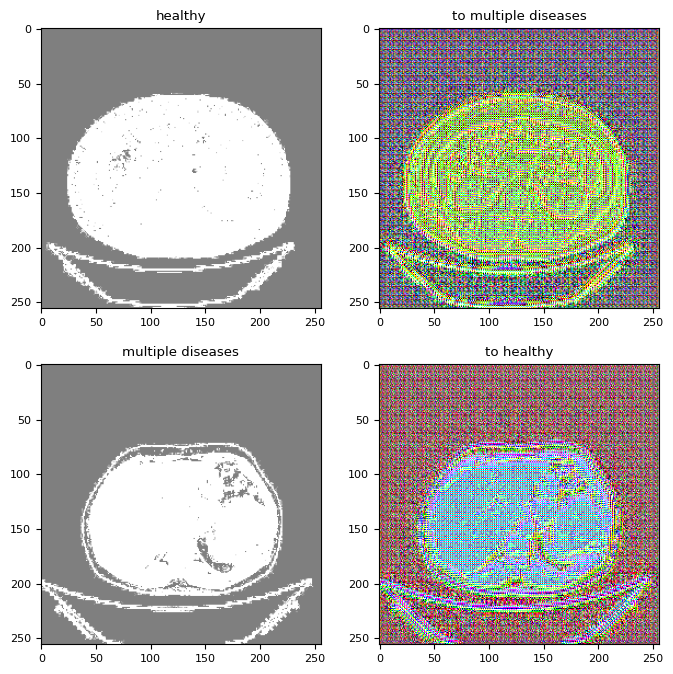

In [ ]:
to_md = generator_g(sample_healthy_image)
to_healthy = generator_f(sample_md_image)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8, 8))
contrast = 8
imgs = [sample_healthy, to_md, sample_md, to_healthy]
title = ['healthy', 'to multiple diseases', 'multiple diseases', 'to healthy']

for i, img in enumerate(imgs):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])

    # Convert the image tensor to a NumPy array, remove the batch dimension, and ensure homogeneous shape (height, width, channels)
    img_np = np.array(img[0])  # Convert to NumPy array and remove batch dimension
    img_np = np.squeeze(img_np)  # Remove the batch dimension

    if i % 2 == 0:
        plt.imshow(img_np * 0.5 + 0.5)  # Convert to NumPy array before arithmetic operations
    else:
        plt.imshow(img_np * 0.5 * contrast + 0.5)  # Convert to NumPy array before arithmetic operations

plt.show()

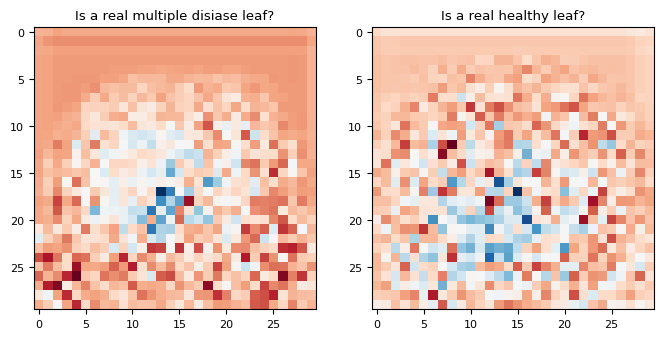

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real multiple disiase leaf?')
plt.imshow(discriminator_y(sample_md_image)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real healthy leaf?')
plt.imshow(discriminator_x(sample_healthy_image)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image-cycled_image))
    return LAMBDA * 0.5 * loss1

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    generator_g = generator_g,
    generator_f = generator_f,
    discriminator_x = discriminator_x,
    discriminator_y = discriminator_y,
    generator_g_optimizer = generator_g_optimizer,
    generator_f_optimizer = generator_f_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [ ]:
@tf.function
def train_step(real_x, real_y):
    real_x_image, real_x_label = real_x
    real_y_image, real_y_label = real_y

    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x_image, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y_image, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x_image, training=True)
        same_y = generator_g(real_y_image, training=True)

        disc_real_x = discriminator_x(real_x_image, training=True)
        disc_real_y = discriminator_y(real_y_image, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x_image, cycled_x) + calc_cycle_loss(real_y_image, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y_image, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x_image, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    # Return the losses for monitoring (if needed)
    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [ ]:
import tensorflow as tf
import time
from tensorflow.keras.callbacks import LearningRateScheduler


In [ ]:
def build_LrFunction():
    # Define your learning rate schedule here
    # For example, you can use a step decay schedule
    def step_decay(epoch):
        initial_lr = 0.001
        drop_rate = 0.5
        epochs_drop = 5
        return initial_lr * drop_rate**(np.floor((1 + epoch) / epochs_drop))

    return step_decay


In [ ]:
lrfn = build_LrFunction()
lr_schedule = LearningRateScheduler(lrfn, verbose=1)


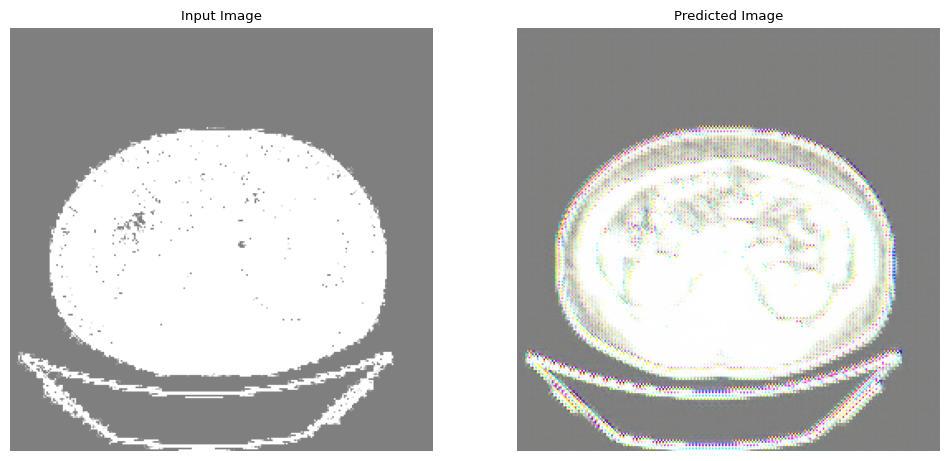

Time taken for epoch 1 is 187.98268675804138 sec



In [ ]:
EPOCHS = 1  # Set the number of training epochs

for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_healthy, image_md in tf.data.Dataset.zip((train_healthy, train_md)):
        # Assuming train_step() takes image_healthy and image_md as input for training
        train_step(image_healthy, image_md)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_healthy) for visualization
    generate_images(generator_g, sample_healthy_image)

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))

ckpt_save_path = ckpt_manager.save()


## Visualize Generated Images

In [ ]:
disp_img=[]
md_gan=[]
for image_ ,label_ in tf.data.Dataset.zip(train_healthy):
    disp_img.append(image_)
    prediction_ = generator_g(image_)
    md_gan.append(prediction_[0].numpy() * 0.5 + 0.5)

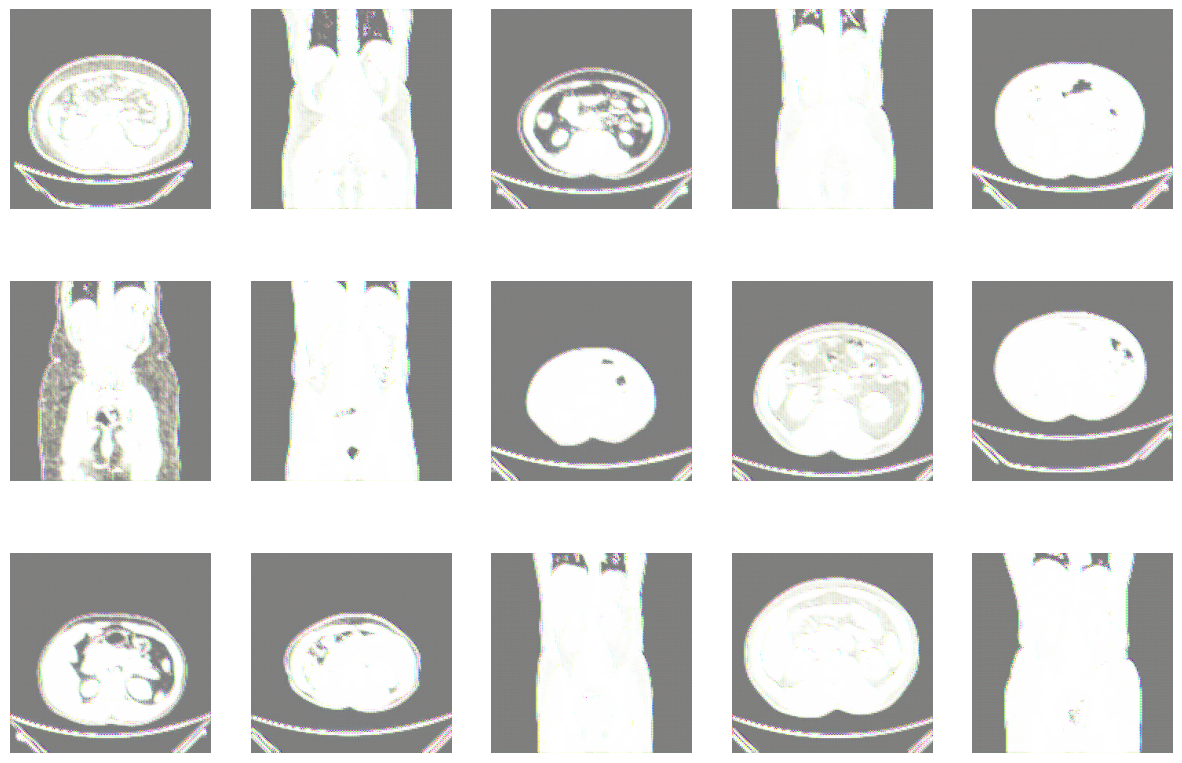

In [ ]:
fig, axis =plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    # getting the pixel values between [0, 1] to plot it.
    ax.imshow(md_gan[i])
    ax.axis('off')


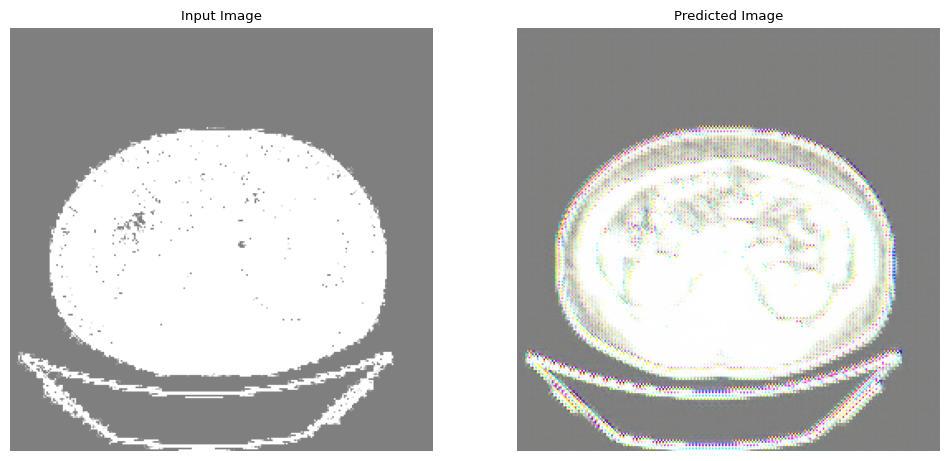

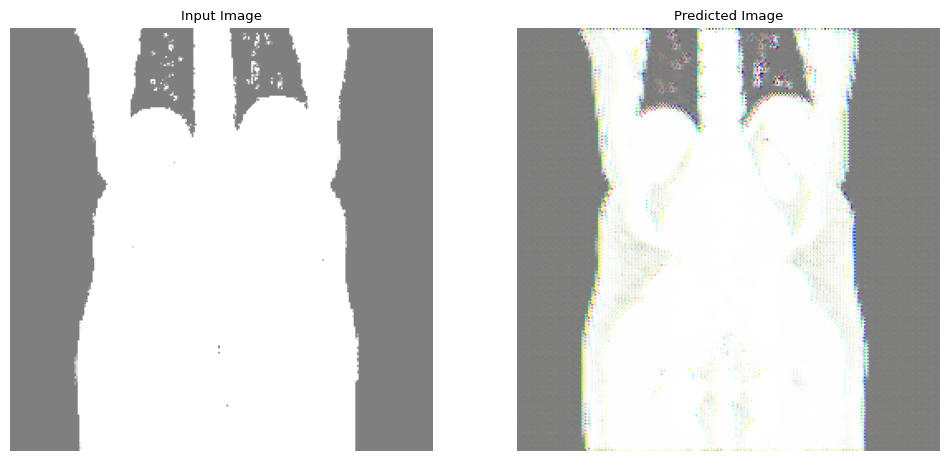

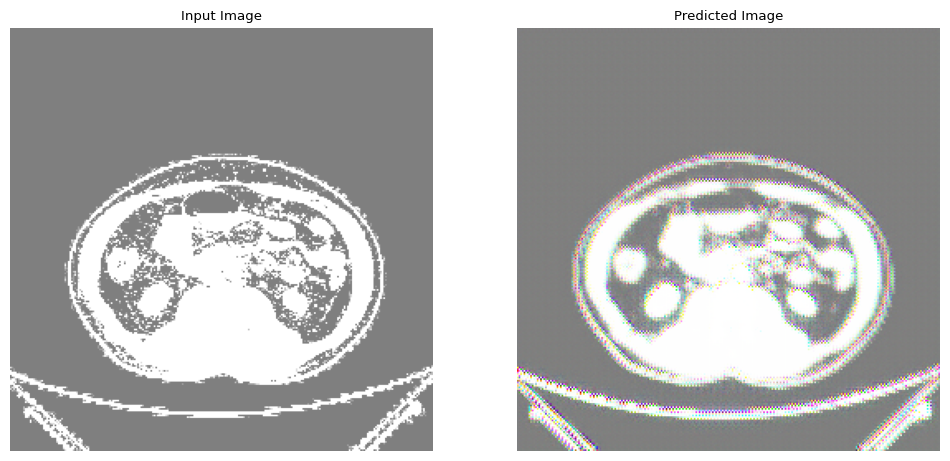

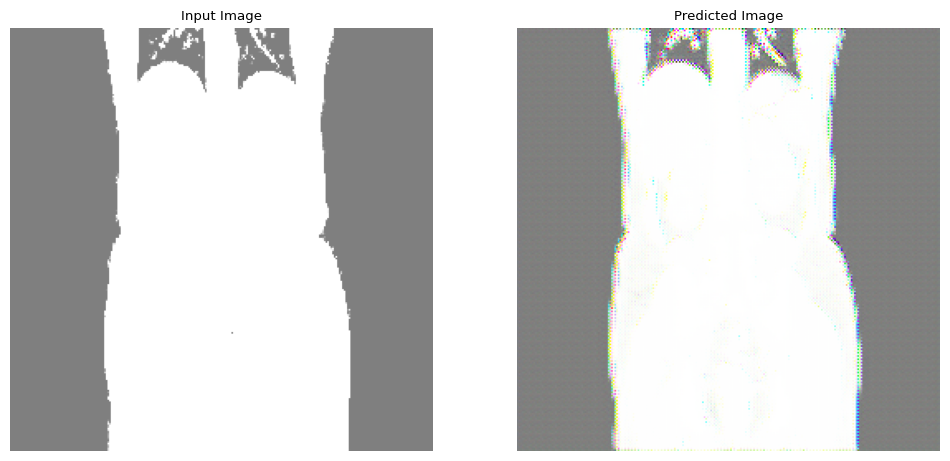

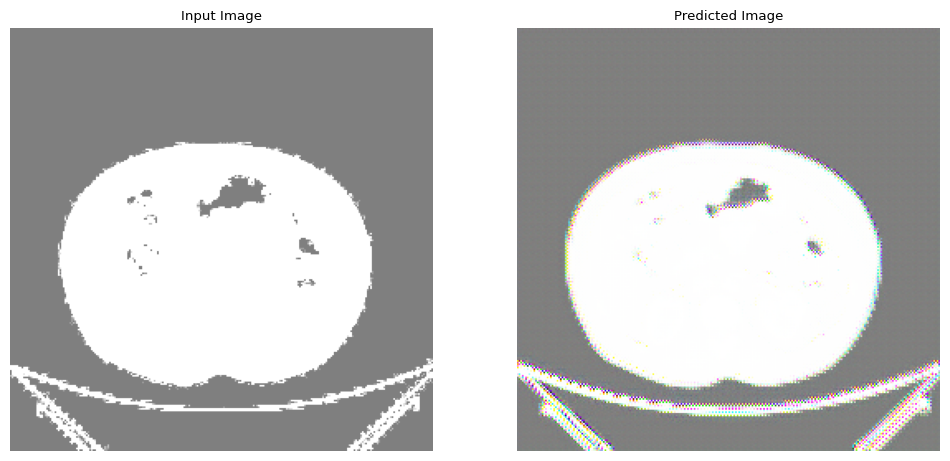

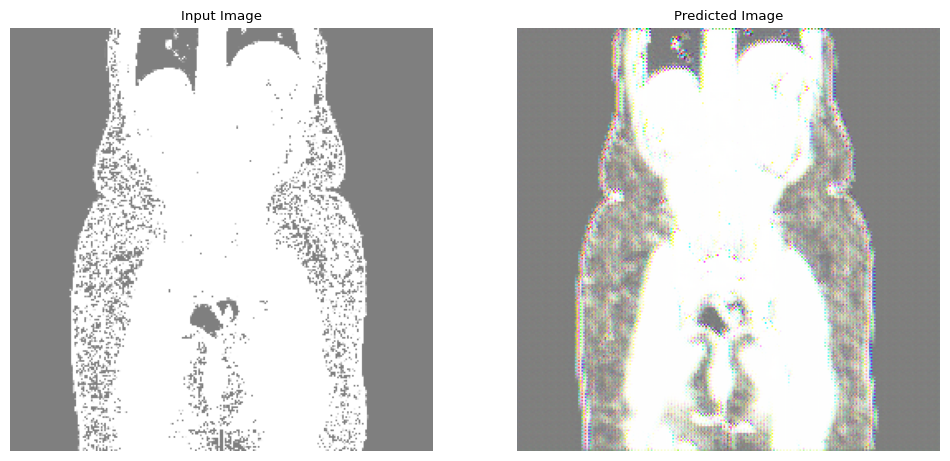

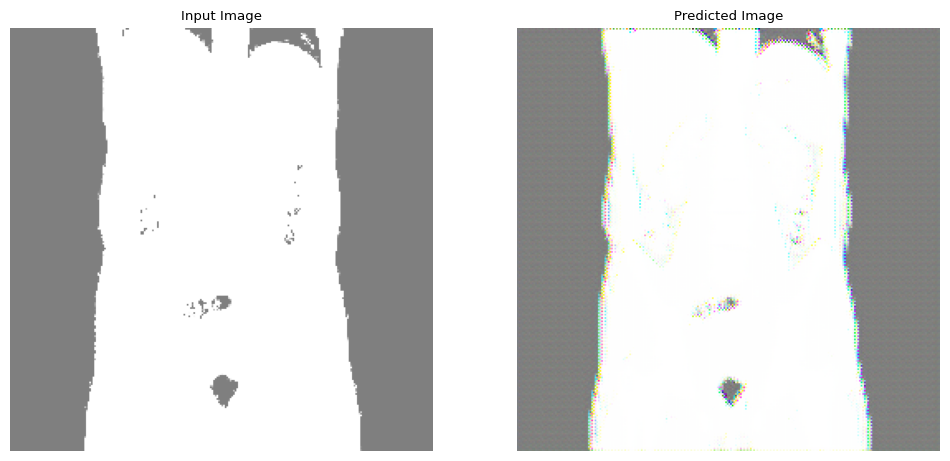

In [ ]:
for i in range(7):
    generate_images(generator_g, disp_img[i])

## Thank YOU

In [ ]:

!pip install tensorflow-gan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-fid

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
import numpy as np

def calculate_inception_score(images, batch_size=32):
    inception_model = InceptionV3(include_top=False, pooling='avg')
    images_array = np.array(images)  # Convert the list of images to a NumPy array
    p_yx = inception_model.predict(preprocess_input(images_array))
    p_y = np.expand_dims(p_yx.mean(axis=0), axis=0)
    kl_d = p_yx * (np.log(p_yx) - np.log(p_y))
    final_score = np.exp(kl_d.mean())
    return final_score

# Assuming md_gan contains generated images as a list of NumPy arrays


In [ ]:
md_gan_np = np.array(disp_img[1])
inception_score = calculate_inception_score(md_gan_np)

print("Inception Score:", inception_score)


1/1 [==============================] - 2s 2s/step
Inception Score: nan


<ipython-input-59-f40142828b02>:11: RuntimeWarning: divide by zero encountered in log
  kl_d = p_yx * (np.log(p_yx) - np.log(p_y))
<ipython-input-59-f40142828b02>:11: RuntimeWarning: invalid value encountered in subtract
  kl_d = p_yx * (np.log(p_yx) - np.log(p_y))
